## Imports and functions (some imports also later on)

In [1]:
import pickle
import pandas as pd
import numpy as np
import logging

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

logging.basicConfig(level=logging.INFO)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Display floats without scientific notation
sns.set(palette='bright')  # Set bright style for Seaborn

In [2]:
def duplicates(X, round=None) -> list:
    """Drop duplicate columns in dataframe

    :param X: input dataframe
    :type X: pandas.core.frame.DataFrame
    :param round: decimal point used for rounding. If set the dataframe is scaled with MinMaxScaler \
    and rounded to the given precision, afterward duplicates are removed. This allows to drop duplicates avoiding \
    floating point precision issues
    :type round: int
    :return: list of columns that are duplicates
    """

    X_ = X.copy()
    if round is not None:
        scaler = MinMaxScaler()
        X_ = pd.DataFrame(scaler.fit_transform(X_),
                          columns=X_.columns,
                          index=X_.index)
        X_ = X_.round(round)
    return X_.columns[X_.T.duplicated()].tolist()


def correlated(X, threshold=0.95) -> list:
    """Decorrelate dataframe by finding which columns shall \
    be removed to achieve correlation level below threshold

    :param X: input dataframe
    :type X: pandas.core.frame.DataFrame
    :param threshold: maximum correlation allowed in the frame X
    :type threshold: float
    :return: list of columns to prune in order to achieve desired decorrelation level
    """

    X_ = X.copy()
    N = X_.shape[1]
    corr = X_.corr().abs()

    to_drop = set()
    for i in range(N - 1):
        for j in range(i + 1, N):
            if corr.iloc[i][j] > threshold and i not in to_drop:
                to_drop.add(j)
    return [X_.columns[i] for i in to_drop]

## Data Preparation

In [3]:
  # read pickle file
pickle_input = "datasets_AM/all_data_cleaned_properties.pkl"
print("\nReading pickle file: ", pickle_input)
with open(pickle_input, "rb") as f:
    df_full = pickle.load(f)
print(df_full.shape) 
print(df_full.head(2))


Reading pickle file:  datasets_AM/all_data_cleaned_properties.pkl
(13219, 153)
     pKa       Source                        ISO_SMI  marvin_pKa  ID  MolLogP  \
0  6.790  DataWarrior             NS(=O)(=O)C(F)(F)I         NaN   1    0.260   
1 11.870  DataWarrior  CCOC(=O)C(Cc1cccc(C)c1)C(C)=O         NaN   2    2.306   

   MolMR   MolWt  NHOHCount  NOCount  ...  MQN33  MQN34  MQN35  MQN36  MQN37  \
0 32.074 256.999          2        3  ...      0      0      0      0      0   
1 65.687 234.295          0        3  ...      0      0      0      1      0   

   MQN38  MQN39  MQN40  MQN41  MQN42  
0      0      0      0      0      0  
1      0      0      0      0      0  

[2 rows x 153 columns]


## remove an external test set
### unfortunately only novartis test set has marvin pka available

In [4]:
# Ensure 'marvin_pKA' exists in the dataframe
assert 'marvin_pKa' in df_full.columns, "'marvin_pKa' does not exist in the dataframe"
# Filter the dataframe where 'marvin_pKA' is not NaN
df_marvin_pKA_not_nan = df_full[df_full['marvin_pKa'].notna()]
# Calculate 10% of the length of the filtered dataframe
sample_size = int(0.25 * len(df_marvin_pKA_not_nan))
# Randomly select 10% of the data from the filtered dataframe
external_test_set = df_marvin_pKA_not_nan.sample(n=sample_size, random_state=42)
# Remove the randomly selected data from the filtered dataframe to create the training set
df_full = df_full.drop(external_test_set.index)
df=df_full.drop(['Source', 'ISO_SMI', 'marvin_pKa', 'ID'], axis=1,  errors="ignore")
df.describe()
df.shape

(13149, 149)

### Show pKa distribution

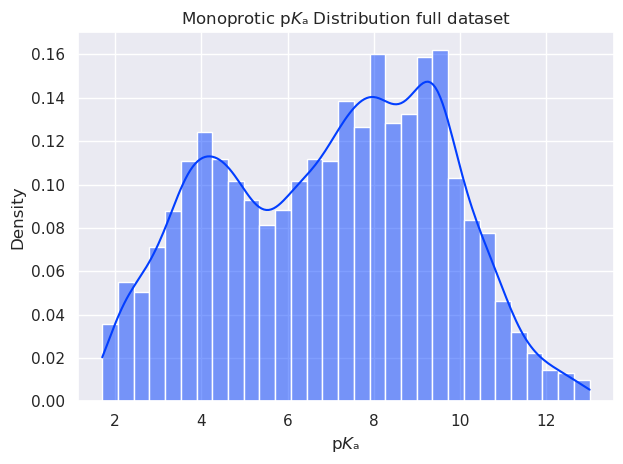

In [5]:
sns_major, sns_minor = map(int, sns.__version__.split('.')[:2])
plt.figure(dpi=100)
if sns_major > 0 or sns_minor >= 11:
    sns.histplot(df.pKa, kde=True, stat='density')
else:
    sns.distplot(df.pKa)
plt.ylabel('Density')
plt.xlabel('p$K$ₐ')
plt.title('Monoprotic p$K$ₐ Distribution full dataset')
plt.tight_layout()
plt.show()

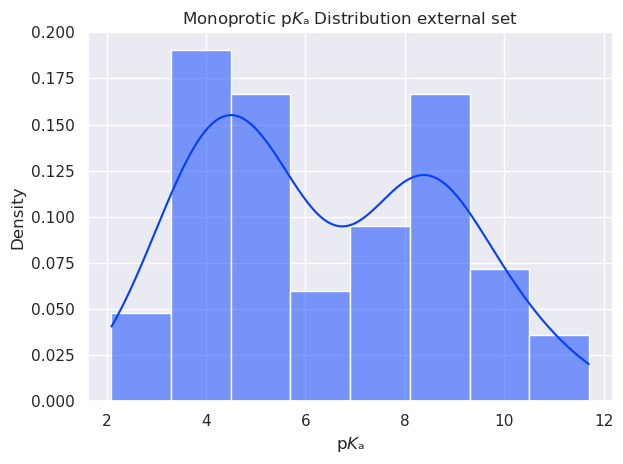

In [6]:
sns_major, sns_minor = map(int, sns.__version__.split('.')[:2])
plt.figure(dpi=100)
if sns_major > 0 or sns_minor >= 11:
    sns.histplot(external_test_set.pKa, kde=True, stat='density')
else:
    sns.distplot(external_test_set.pKa)
plt.ylabel('Density')
plt.xlabel('p$K$ₐ')
plt.title('Monoprotic p$K$ₐ Distribution external set')
plt.tight_layout()
plt.show()

### Scaling/Normalization to 0 & 1  
-> there are different methods of doing this, but it doesn't really seem to matter, so sticking to MinMax

In [7]:
#scaler = MinMaxScaler()
#df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [8]:
#df.head()

Define X and y:

In [9]:
X, y = df.loc[:, df.columns != 'pKa'], df['pKa']
print (f"Number of features: {X.shape[1]}, number of samples: {X.shape[0]}")

Number of features: 148, number of samples: 13149


### Preprocessing

Drop NaN columns (#TODO don't calculate these descriptors to begin with)

In [10]:
nan_columns = X.columns[X.isna().any()].tolist()
X = X.drop(nan_columns, axis=1)
print("Removed columns:", nan_columns)

Removed columns: []


Drop columns with no variance

In [11]:
zero_std = X.std()[X.std() == 0].index
display(f"Zero std columns: {len(zero_std)}")
X = X[X.columns.difference(zero_std)]

'Zero std columns: 5'

Drop columns that are duplicates of some other columns


In [12]:
dupes = duplicates(X, round=3)
display(f"Duplicate columns: {len(dupes)}")
X = X[X.columns.difference(dupes)]

'Duplicate columns: 4'

In [13]:
print(dupes)

['MQN12', 'MaxEStateIndex', 'NHOHCount', 'NumRotatableBonds']


Drop columns very highly correlated to some other columns

In [14]:
high_corr = correlated(X, threshold=0.99)
display(f"Correlated features: {len(high_corr)}")
X = X[X.columns.difference(high_corr)]

'Correlated features: 7'

In [15]:
print (f"Number of features: {X.shape[1]}, number of samples: {X.shape[0]}")

Number of features: 132, number of samples: 13149


## Dimensionality reduction

Multiple Options. Just for checking, will skip usage most likely

### PCA (option 1)
Principal component analysis. Diagonalize covariance of X and order the eigenvectors by their variance.

<AxesSubplot: >

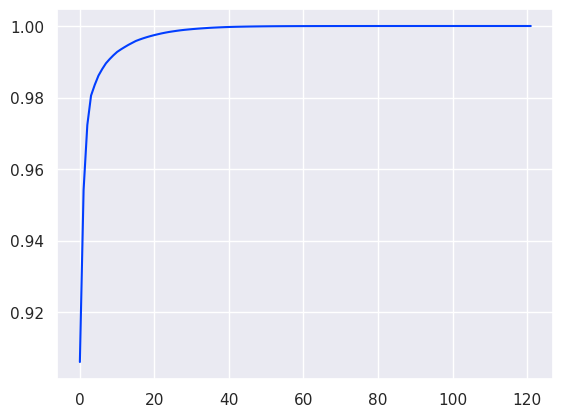

In [16]:
p = PCA()
X_pca = p.fit_transform(X)
explained_var = pd.Series(p.explained_variance_ratio_.cumsum())
explained_var[explained_var < 1].plot(grid=True)

In [17]:
n_pc = 80 # close to 1 acc. to plot
X_pca = X_pca[:, :n_pc]

### Decorrelation (option 2)
Remove features sequentially by iteratively reducing the correlation thershold, until a desired amount of features remains.

In [18]:
n_features = 100
X_decorr = X.copy()
th = 0.99
while X_decorr.shape[1] > n_features:
    print (f" correlation threshold: {th}, number of features: {X_decorr.shape[1]}")
    high_corr = correlated(X_decorr, threshold=th)
    X_decorr = X_decorr[X_decorr.columns.difference(high_corr)]
    th = round(th - 0.01, 2)

 correlation threshold: 0.99, number of features: 132
 correlation threshold: 0.98, number of features: 132
 correlation threshold: 0.97, number of features: 125
 correlation threshold: 0.96, number of features: 122
 correlation threshold: 0.95, number of features: 121
 correlation threshold: 0.94, number of features: 118
 correlation threshold: 0.93, number of features: 117
 correlation threshold: 0.92, number of features: 115
 correlation threshold: 0.91, number of features: 113
 correlation threshold: 0.9, number of features: 112
 correlation threshold: 0.89, number of features: 110
 correlation threshold: 0.88, number of features: 107
 correlation threshold: 0.87, number of features: 104
 correlation threshold: 0.86, number of features: 102
 correlation threshold: 0.85, number of features: 101


# Modelling
(Spelling that has nagged me: US modeling; UK modelling)

Select ```X_reg``` features to use, either the entire ```X``` matrix, or one of the ```X_pca```, ```X_decorr```

In [19]:
X_reg = X.copy()  # using all, since it's small dataset and the reduction didn't make a (huge?) difference
X_reg = pd.DataFrame(X_reg, index=df.index) # redundant

### Train/test dataset

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_reg, 
                                                    y,
                                                    train_size=0.85, 
                                                    random_state=42)

### Random Forest (regression)

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [37]:
rf = RandomForestRegressor(n_estimators=100, max_features='auto', max_depth=None, min_samples_split=2, n_jobs=-1)

In [38]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

/home/alex/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


 R2: 0.6102, MAE: 1.0604


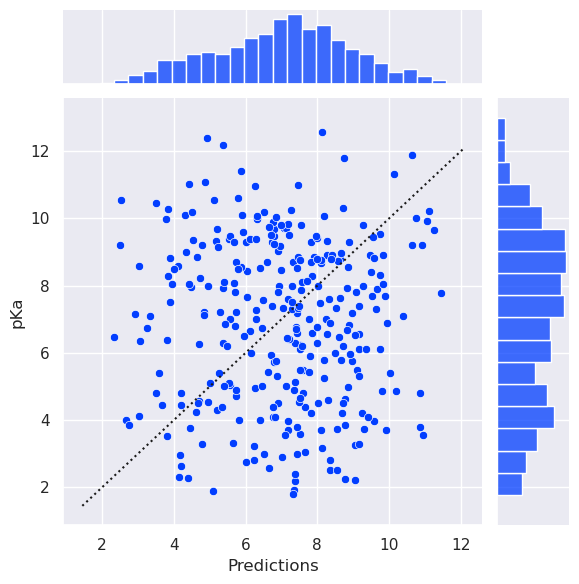

In [39]:
print (f" R2: {round(r2_score(y_test, y_pred), 4)}, MAE: {round(mean_absolute_error(y_test, y_pred), 4)}")

data=pd.concat([pd.Series(y_pred), pd.Series(y_test)], axis=1)
data.columns=['Predictions', 'pKa']

g = sns.jointplot(x='Predictions', y='pKa', data=data)
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')   

In [25]:
external_X = external_test_set.drop(['Source', 'ISO_SMI', 'ID'], axis=1,  errors="ignore")
#scaler
#scaler = MinMaxScaler()
#external_X = pd.DataFrame(scaler.transform(external_X), columns=external_X.columns, index=external_X.index)
external_Y = external_X['marvin_pKa']
external_Y_list = external_Y.values.tolist()
external_X = external_X.drop(['marvin_pKa'], axis=1,  errors="ignore")
external_test_set = external_X.reindex(columns=X.columns)


In [26]:
external_test_predictions = rf.predict(external_test_set)

 R2: -0.1358, MAE: 2.2634


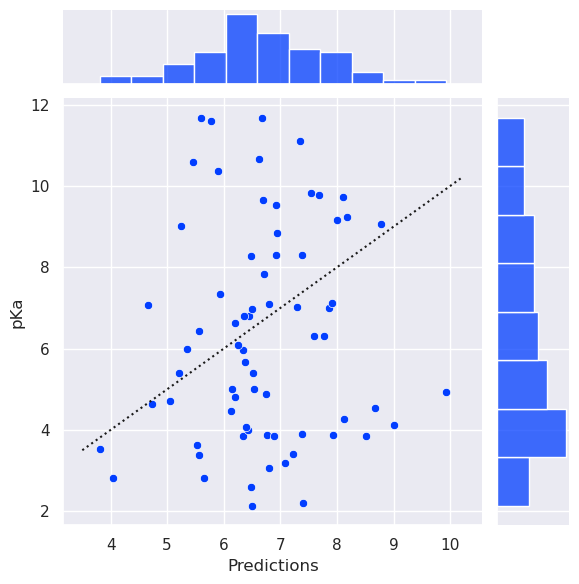

In [27]:
print (f" R2: {round(r2_score(external_Y_list, external_test_predictions), 4)}, MAE: {round(mean_absolute_error(external_Y_list, external_test_predictions), 4)}")

data=pd.concat([pd.Series(external_test_predictions), pd.Series(external_Y_list)], axis=1)
data.columns=['Predictions', 'pKa']

g = sns.jointplot(x='Predictions', y='pKa', data=data)
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')   